In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import dateutil as du
import calendar
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.kernel_ridge import *
from sklearn.neural_network import *
from sklearn.dummy import DummyRegressor

#df = pd.read_csv("data/chicago_crime_thefts_filtered_v2.csv", )

#weather = pd.read_csv("data/chicago-weather.csv", parse_dates=True, index_col='DATE')

%matplotlib inline

In [871]:
districts = df['District'].unique()

errors = []
crimes = []

for district in districts:
    subset = df[df['District'] == district]
    s = subset.groupby(['DateOnly']).size()
    idx = pd.date_range('2001-01-01', '2018-01-26')
    s = s.reindex(idx, fill_value=0)
    s = s[:-90]
    
    X = pd.DataFrame(s, columns=['Thefts'])
    for n in range (1,29):
        X['Thefts_-'+str(n)+"_days"] = X.Thefts.shift(n)
        
        
    X['Thefts_-2-5_day_mean'] = (X['Thefts_-2_days'] + X['Thefts_-3_days'] + X['Thefts_-4_days'] + X['Thefts_-5_days']) / 4
    X['Thefts_-2-7_day_mean'] = (X['Thefts_-2_days'] + X['Thefts_-3_days'] + X['Thefts_-4_days'] + X['Thefts_-5_days'] + X['Thefts_-6_days'] + X['Thefts_-7_days']) / 6
    X['Thefts_-2_day_of_week_mean'] = (X['Thefts_-7_days'] + X['Thefts_-14_days']) / 2
    X['Thefts_-3_day_of_week_mean'] = (X['Thefts_-7_days'] + X['Thefts_-14_days'] + X['Thefts_-21_days']) / 3
    X['Thefts_-4_day_of_week_mean'] = (X['Thefts_-7_days'] + X['Thefts_-14_days'] + X['Thefts_-21_days'] + X['Thefts_-28_days']) / 4
    
    X = X.dropna(axis=0, how='any')
    
    
    X_train = X[:5000]
    X_test = X[5000:]
    y_train = X_train.pop('Thefts')
    y_test = X_test.pop('Thefts')
    
    model = RandomForestRegressor(n_estimators=100)
    
    model.fit(X_train,y_train)
    
    y_hat = model.predict(X_test)
    mae = np.median(np.abs(y_test-y_hat))
    errors.append(mae)
    crimes.append(np.median(y_test))
    
    print("District", district, "MAE:", round(mae,3), "mean predict:", round(np.mean(y_hat),3),"mean thefts:", round(np.mean(y_test),3))

print(np.mean(errors)/np.mean(crimes))   

District 11.0 MAE: 1.8 mean predict: 5.928 mean thefts: 5.201
District 6.0 MAE: 2.25 mean predict: 8.667 mean thefts: 7.873
District 14.0 MAE: 2.48 mean predict: 9.602 mean thefts: 9.212
District 19.0 MAE: 2.86 mean predict: 12.14 mean thefts: 11.435
District 7.0 MAE: 2.66 mean predict: 7.054 mean thefts: 4.905
District 2.0 MAE: 2.11 mean predict: 7.387 mean thefts: 6.944
District 18.0 MAE: 3.15 mean predict: 16.315 mean thefts: 15.977
District 25.0 MAE: 2.33 mean predict: 8.587 mean thefts: 7.438
District 17.0 MAE: 2.0 mean predict: 6.17 mean thefts: 5.669
District 3.0 MAE: 1.86 mean predict: 6.033 mean thefts: 5.217
District 12.0 MAE: 2.6 mean predict: 11.658 mean thefts: 11.088
District 24.0 MAE: 1.76 mean predict: 5.371 mean thefts: 4.902
District 8.0 MAE: 2.75 mean predict: 10.155 mean thefts: 9.013
District 16.0 MAE: 1.92 mean predict: 6.264 mean thefts: 5.611
District 1.0 MAE: 3.28 mean predict: 16.966 mean thefts: 17.104
District 4.0 MAE: 2.1 mean predict: 7.157 mean thefts: 6.

In [249]:
def roll(data):
    rows, cols = data.shape
    errors = []
    
    results = pd.DataFrame()
    
    for n in range(5106,rows-1):
        X_train = data[:n]
        X_test = data[n:n+1]
        y_train = X_train.pop('Thefts')
        y_test = X_test.pop('Thefts')
        
        
        model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.5, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=8,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
        
        weights = np.logspace(0,1,num=n,base=2)-1
        model.fit(X_train, y_train, sample_weight=weights)
        y_hat = model.predict(X_test)
        
        #dummy = DummyRegressor()
        #dummy.fit(X_train, y_train, sample_weight=weights)
        #y_dummy = dummy.predict(X_test)
        
        results = results.append(pd.Series({'y':y_test.get_values()[0], 'y_hat':y_hat[0]}, name=y_test.index.get_values()[0]))
        
        if (n % 25 == 0):
            print(n)
            print(results.tail(2))
        
    return results

In [255]:
log.to_csv("log_results.csv")

In [254]:
l.tail(20)

y     y_dummy       y_hat
2017-12-11  190.0  195.534216  173.800923
2017-12-12  187.0  195.532313  166.858288
2017-12-13  176.0  195.529379  175.248777
2017-12-14  176.0  195.522664  161.480755
2017-12-15  174.0  195.515953  182.554579
2017-12-16  211.0  195.508558  176.578197
2017-12-17  173.0  195.513881  143.395838
2017-12-18  205.0  195.506146  181.558617
2017-12-19  218.0  195.509407  178.732857
2017-12-20  175.0  195.517132  175.281332
2017-12-21  202.0  195.510086  173.582923
2017-12-22  206.0  195.512315  183.163223
2017-12-23  194.0  195.515915  177.611843
2017-12-24  134.0  195.515395  151.225291
2017-12-25   68.0  195.494284  184.428744
2017-12-26  124.0  195.450540  181.286083
2017-12-27  115.0  195.426028  166.103035
2017-12-28  161.0  195.398443  152.742767
2017-12-29  155.0  195.386646  164.028296
2017-12-30  144.0  195.372798  158.082048

In [244]:
r.to_csv("city_results.csv")

In [245]:
l.to_csv("linear_results.csv")

In [307]:
def extract(df):
    
    date_group = df.groupby(['Date'])
    #print(date_group.head())
    s = date_group.size()
    #print(s.head())
    idx = pd.date_range('2001-01-01', '2017-12-31')
    s = s.reindex(idx, fill_value=0)
    #print(s.head())
    X = pd.DataFrame(s, columns=['Thefts'])
    #print(X.head())
    
    X['UniqueLocations'] = date_group.Block.nunique()
    X['Under500'] = df[df['Description'] == "$500 AND UNDER"].groupby(['Date']).size()
    X['Over500'] = df[df['Description'] == "OVER $500"].groupby(['Date']).size()
    X['FromBuilding'] = df[df['Description'] == "FROM BUILDING"].groupby(['Date']).size()
    X['Retail'] = df[df['Description'] == "RETAIL THEFT"].groupby(['Date']).size()
    X['TotalArrests'] = df[df['Arrest'] == True].groupby(['Date']).size()
    
    X['ArrestRate'] = X['TotalArrests']/X['Thefts']
    X['UniqueLocationRate'] = X['UniqueLocations']/X['Thefts']
    
    return X.fillna(value=0)

In [20]:
ex = extract(df)

In [21]:
ex.tail()

Thefts  UniqueLocations  Under500  Over500  FromBuilding  Retail  \
2017-12-27     115              108        39       23           0.0     0.0   
2017-12-28     161              150        60       43           0.0     0.0   
2017-12-29     155              145        45       35           0.0     0.0   
2017-12-30     144              132        65       19           0.0     0.0   
2017-12-31      99               95        40       16           0.0     0.0   

            TotalArrests  ArrestRate  UniqueLocationRate  
2017-12-27            15    0.130435            0.939130  
2017-12-28            19    0.118012            0.931677  
2017-12-29            22    0.141935            0.935484  
2017-12-30            18    0.125000            0.916667  
2017-12-31            15    0.151515            0.959596

In [22]:
def lag(df):
    
    cols = list(df)
    X = df.copy()
    
    for col in cols:
        for n in range(2,36):
            X[col+'_-'+str(n)] = X[col].shift(n)
        
        X[col+'_-357'] = X[col].shift(357)
        X[col+'_-364'] = X[col].shift(364)
        X[col+'_-371'] = X[col].shift(371)
        X[col+'_-1y_week_day_mean'] = (X[col].shift(357) + X[col].shift(364) + X[col].shift(371)) / 3
        X[col+'_-1y_week_mean'] = (X[col].shift(360) + X[col].shift(362) + X[col].shift(363) + X[col].shift(364) + X[col].shift(365) + X[col].shift(367) + X[col].shift(368)) / 7       
          
        X[col+'_7_day_mean'] = (X[col+'_-2'] + X[col+'_-3'] + X[col+'_-4'] + X[col+'_-5'] + X[col+'_-6'] + X[col+'_-7']) / 6
        X[col+'_2_day_of_week_mean'] = (X[col+'_-7'] + X[col+'_-14']) / 2
        X[col+'_3_day_of_week_mean'] = (X[col+'_-7'] + X[col+'_-14'] + X[col+'_-21']) / 3
        X[col+'_4_day_of_week_mean'] = (X[col+'_-7'] + X[col+'_-14'] + X[col+'_-21'] + X[col+'_-28']) / 4
        X[col+'_5_day_of_week_mean'] = (X[col+'_-7'] + X[col+'_-14'] + X[col+'_-21'] + X[col+'_-28'] + X[col+'_-35']) / 5
    
    cols.remove('Thefts')
    X = X.drop(cols, axis=1)
    
    return X.dropna(axis=0, how='any')
    

In [311]:
districts = df['District'].unique()
results = pd.DataFrame()

for district in districts:
        
    subset = df[df['District'] == district]
    subset_ex = extract(subset)
    subset_px = lag(subset_ex)
    
    subset_px = subset_px.merge(weather, left_index=True, right_index=True, how='inner')
        
    rows, cols = subset_px.shape
    
    X_train = subset_px[:5106]
    X_test = subset_px[5106:]
    y_train = X_train.pop('Thefts')
    y_test = X_test.pop('Thefts')

    model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                   max_features=0.5, max_leaf_nodes=None,
                   min_impurity_decrease=0.5, min_impurity_split=None,
                   min_samples_leaf=1, min_samples_split=20,
                   min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=6,
                   oob_score=False, random_state=None, verbose=0, warm_start=False)


    model.fit(X_train,y_train)
    y_hat = model.predict(X_test)

    dummy = DummyRegressor()
    dummy.fit(X_train,y_train)
    y_dummy = dummy.predict(X_test)

    results = results.append(pd.DataFrame({'distric':district, 'y':y_test.get_values(), 'y_hat':y_hat, 'y_dummy':y_dummy}))
    print(results.tail(9))

     distric  y   y_dummy     y_hat
720     15.0  2  4.999608  5.000719
721     15.0  4  4.999608  5.000719
722     15.0  4  4.999608  5.000719
723     15.0  3  4.999608  5.000719
724     15.0  6  4.999608  5.000719
725     15.0  4  4.999608  5.000719
726     15.0  1  4.999608  5.000719
727     15.0  3  4.999608  5.000719
728     15.0  1  4.999608  5.000719
     distric  y   y_dummy     y_hat
720      7.0  6  8.550333  7.086929
721      7.0  6  8.550333  7.086929
722      7.0  3  8.550333  7.086929
723      7.0  6  8.550333  7.086929
724      7.0  3  8.550333  7.086929
725      7.0  7  8.550333  7.086929
726      7.0  6  8.550333  7.086929
727      7.0  2  8.550333  7.086929
728      7.0  6  8.550333  7.086929
     distric  y   y_dummy     y_hat
720      4.0  5  9.929886  8.218914
721      4.0  7  9.929886  8.248130
722      4.0  1  9.929886  8.218914
723      4.0  7  9.929886  8.218914
724      4.0  6  9.929886  8.218914
725      4.0  6  9.929886  8.218914
726      4.0  5  9.929886  8

In [313]:
results.to_csv("district_results.csv")

In [277]:
subset.sample(10)

ID Case Number        Date                 Block  IUCR  \
139435  11122252    JA476155  2017-10-18   0000X S CENTRAL AVE   820   
890880  10836165    JA137998  2017-02-01    052XX W MADISON ST   860   
746740   3825243    HL196020  2005-02-22   053XX W CHICAGO AVE   820   
443811   1788306     G609162  2001-10-10       059XX W IOWA ST   820   
893903  10855353    JA160544  2017-02-19     059XX W WALTON ST   820   
694041   9250100    HW395685  2013-08-04   059XX W MIDWAY PARK   820   
999172   3571054    HK657789  2004-09-30    054XX W MADISON ST   860   
936401   3082841    HJ807623  2003-12-08  0000X S MAYFIELD AVE   820   
410052   1586422     G347805  2001-06-15     059XX W MIDWAY PK   820   
574523   8143146    HT377267  2011-07-02    001XX N MENARD AVE   820   

       Primary Type     Description Location Description  Arrest  Domestic  \
139435        THEFT  $500 AND UNDER                OTHER   False     False   
890880        THEFT    RETAIL THEFT           DRUG STORE    True     False   
746740        THEFT  $500 AND UNDER               STREET   False     False   
443811        THEFT  $500 AND UNDER               STREET   False     False   
893903        THEFT  $500 AND UNDER               STREET   False     False   
694041        THEFT  $500 AND UNDER            RESIDENCE   False     False   
999172        THEFT    RETAIL THEFT  TAVERN/LIQUOR STORE    True     False   
936401        THEFT  $500 AND UNDER               STREET   False     False   
410052        THEFT  $500 AND UNDER               STREET   False     False   
574523        THEFT  $500 AND UNDER               STREET   False     False   

               ...           FBI Code  X Coordinate  Y Coordinate  Year  \
139435         ...                  6     1139061.0     1899321.0  2017   
890880         ...                  6     1141512.0     1899523.0  2017   
746740         ...                  6     1140614.0     1904816.0  2005   
443811         ...                  6     1136938.0     1905439.0  2001   
893903         ...                  6     1136688.0     1905725.0  2017   
694041         ...                  6     1136677.0     1902627.0  2013   
999172         ...                  6     1139929.0     1899485.0  2004   
936401         ...                  6     1137282.0     1899312.0  2003   
410052         ...                  6     1136352.0     1902580.0  2001   
574523         ...                  6     1137687.0     1900570.0  2011   

                    Updated On   Latitude  Longitude  \
139435  02/10/2018 03:50:01 PM  41.879853 -87.764852   
890880  02/14/2017 03:49:42 PM  41.880362 -87.755847   
746740  02/10/2018 03:50:01 PM  41.894903 -87.759015   
443811  08/17/2015 03:03:40 PM  41.896680 -87.772501   
893903  02/10/2018 03:50:01 PM  41.897469 -87.773412   
694041  02/10/2018 03:50:01 PM  41.888968 -87.773527   
999172  02/28/2018 03:56:25 PM  41.880287 -87.761661   
936401  02/28/2018 03:56:25 PM  41.879860 -87.771385   
410052  08/17/2015 03:03:40 PM  41.888845 -87.774722   
574523  02/10/2018 03:50:01 PM  41.883305 -87.769867   

                             Location             DateTime  \
139435  (41.879852674, -87.764852301)  2017-10-18 16:00:00   
890880  (41.880362084, -87.755847438)  2017-02-01 14:48:00   
746740  (41.894903267, -87.759014768)  2005-02-22 16:00:00   
443811  (41.896679587, -87.772500977)  2001-10-10 16:00:00   
893903  (41.897468888, -87.773412344)  2017-02-19 16:00:00   
694041  (41.888967775, -87.773526986)  2013-08-04 20:00:00   
999172   (41.88028689, -87.761661062)  2004-09-30 17:46:40   
936401  (41.879860127, -87.771384873)  2003-12-08 22:00:00   
410052  (41.888844613, -87.774721656)  2001-06-15 14:50:00   
574523  (41.883304959, -87.769867415)  2011-07-02 17:00:00   

        Coursework Test Set  
139435                 True  
890880                 True  
746740                False  
443811                False  
893903                 True  
694041                False  
999172                Fals

In [301]:
df['Date'] = df['Date'].astype('datetime64[ns]').dt.date

In [304]:
date_group = subset.groupby(['Date'])
s = date_group.size()
print(s.head())
idx = pd.date_range('2001-01-01', '2017-12-31')
s = s.reindex(idx, fill_value=0)
print(s.head())
X = pd.DataFrame(s, columns=['Thefts'])
print(X.head())
    
X['UniqueLocations'] = date_group.Block.nunique()
X['Under500'] = df[df['Description'] == "$500 AND UNDER"].groupby(['Date']).size()
X['Over500'] = df[df['Description'] == "OVER $500"].groupby(['Date']).size()
X['FromBuilding'] = df[df['Description'] == "FROM BUILDING"].groupby(['Date']).size()
X['Retail'] = df[df['Description'] == "RETAIL THEFT"].groupby(['Date']).size()
X['TotalArrests'] = df[df['Arrest'] == True].groupby(['Date']).size()
    
X['ArrestRate'] = X['TotalArrests']/X['Thefts']
X['UniqueLocationRate'] = X['UniqueLocations']/X['Thefts']
X = X.fillna(value=0)
print(X.head())

Date
2001-01-01    13
2001-01-02     5
2001-01-03     6
2001-01-04     3
2001-01-05     3
dtype: int64
2001-01-01    13
2001-01-02     5
2001-01-03     6
2001-01-04     3
2001-01-05     3
Freq: D, dtype: int64
            Thefts
2001-01-01      13
2001-01-02       5
2001-01-03       6
2001-01-04       3
2001-01-05       3
            Thefts  UniqueLocations  Under500  Over500  FromBuilding  Retail  \
2001-01-01      13             12.0       156       77           1.0     0.0   
2001-01-02       5              5.0       136       67           0.0     0.0   
2001-01-03       6              6.0       157       64           0.0     0.0   
2001-01-04       3              3.0       170       68           0.0     0.0   
2001-01-05       3              3.0       165       90           1.0     0.0   

            TotalArrests  ArrestRate  UniqueLocationRate  
2001-01-01            38    2.923077            0.923077  
2001-01-02            33    6.600000            1.000000  
2001-01-03        

In [284]:
date_group = subset.groupby(['Date'])
s = date_group.size()

In [290]:
s.head()

Date
2001-01-01    13
2001-01-02     5
2001-01-03     6
2001-01-04     3
2001-01-05     3
dtype: int64

In [292]:
s.reindex(idx, fill_value=0)

2001-01-01    zero
2001-01-02    zero
2001-01-03    zero
2001-01-04    zero
2001-01-05    zero
2001-01-06    zero
2001-01-07    zero
2001-01-08    zero
2001-01-09    zero
2001-01-10    zero
2001-01-11    zero
2001-01-12    zero
2001-01-13    zero
2001-01-14    zero
2001-01-15    zero
2001-01-16    zero
2001-01-17    zero
2001-01-18    zero
2001-01-19    zero
2001-01-20    zero
2001-01-21    zero
2001-01-22    zero
2001-01-23    zero
2001-01-24    zero
2001-01-25    zero
2001-01-26    zero
2001-01-27    zero
2001-01-28    zero
2001-01-29    zero
2001-01-30    zero
              ... 
2017-12-02    zero
2017-12-03    zero
2017-12-04    zero
2017-12-05    zero
2017-12-06    zero
2017-12-07    zero
2017-12-08    zero
2017-12-09    zero
2017-12-10    zero
2017-12-11    zero
2017-12-12    zero
2017-12-13    zero
2017-12-14    zero
2017-12-15    zero
2017-12-16    zero
2017-12-17    zero
2017-12-18    zero
2017-12-19    zero
2017-12-20    zero
2017-12-21    zero
2017-12-22    zero
2017-12-23  

In [93]:
px = lag(ex)
px = px.merge(weather, left_index=True, right_index=True, how='inner')

In [24]:
px.head()

Thefts  Thefts_-2  Thefts_-3  Thefts_-4  Thefts_-5  Thefts_-6  \
2002-01-07     217      202.0      206.0      211.0      266.0      344.0   
2002-01-08     221      175.0      202.0      206.0      211.0      266.0   
2002-01-09     250      217.0      175.0      202.0      206.0      211.0   
2002-01-10     258      221.0      217.0      175.0      202.0      206.0   
2002-01-11     254      250.0      221.0      217.0      175.0      202.0   

            Thefts_-7  Thefts_-8  Thefts_-9  Thefts_-10  ...   \
2002-01-07      222.0      165.0      217.0       226.0  ...    
2002-01-08      344.0      222.0      165.0       217.0  ...    
2002-01-09      266.0      344.0      222.0       165.0  ...    
2002-01-10      211.0      266.0      344.0       222.0  ...    
2002-01-11      206.0      211.0      266.0       344.0  ...    

            UniqueLocationRate_-371  UniqueLocationRate_-1y_week_day_mean  \
2002-01-07                 0.955556                              0.923675   
2002-01-08                 0.963801                              0.938598   
2002-01-09                 0.920354                              0.917466   
2002-01-10                 0.925926                              0.934711   
2002-01-11                 0.950382                              0.929155   

            UniqueLocationRate_-1y_week_mean  UniqueLocationRate_7_day_mean  \
2002-01-07                          0.921344                       0.944723   
2002-01-08                          0.924263                       0.947760   
2002-01-09                          0.922512                       0.942821   
2002-01-10                          0.916658                       0.942532   
2002-01-11                          0.927364                       0.945641   

            UniqueLocationRate_2_day_of_week_mean  \
2002-01-07                               0.908384   
2002-01-08                               0.973630   
2002-01-09                               0.917852   
2002-01-10                               0.955596   
2002-01-11                               0.944325   

            UniqueLocationRate_3_day_of_week_mean  \
2002-01-07                               0.919839   
2002-01-08                               0.956300   
2002-01-09                               0.909881   
2002-01-10                               0.950397   
2002-01-11                               0.941223   

            UniqueLocationRate_4_day_of_week_mean  \
2002-01-07                               0.921062   
2002-01-08                               0.942835   
2002-01-09                               0.921258   
2002-01-10                               0.938691   
2002-01-11                               0.945656   

            UniqueLocationRate_5_day_of_week_mean  PRCP  TEMP  
2002-01-07                               0.930265   0.0  83.5  
2002-01-08                               0.942353   0.0  86.5  
2002-01-09                               0.924408   0.0  71.0  
2002-01-10                               0.936027   0.0  73.5  
2002-01-11                               0.948751   0.0  37.5  

[5 rows x 399 columns]

In [1390]:
roll(px) #fipped logspace

5000
0.03977900552486181
5250
0.11038828438210734
5500
0.1097901553535577
5750
0.1015729943467846


0.10187846266188631

In [1396]:
roll(px)

5000
0.02371621841115084
5250
0.125848495428919
5500
0.12224941607306697
5750
0.11448557183059715


0.11399768438982667

In [1383]:
roll(px) #logspace(0,2,num=len(X_train),base=10.0

5000
0.03867403314917127
5250
0.118238740323062
5500
0.11418052723309238
5750
0.10475675075649192


0.10460548831804871

In [1381]:
roll(px) # linear

5000
0.007182320441989013
5250
0.11582093429495666
5500
0.11347654652088497
5750
0.10458177821750458


0.10510643474508777

In [1261]:
X_train = px[:5000]
X_test = px[5000:]
y_train = X_train.pop('Thefts')
y_test = X_test.pop('Thefts')

In [86]:
#y = px.pop("Thefts")
model = RandomForestRegressor(max_features=0.1)
cross_validate(model, px, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=7, verbose=3)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ...................... , score=-21.856212510711224, total=   0.9s
[CV] ...................... , score=-25.481319622964865, total=   0.9s
[CV] ....................... , score=-20.27926306769494, total=   0.9s
[CV] ...................... , score=-18.717480719794345, total=   0.9s
[CV] ....................... , score=-17.47240788346187, total=   0.9s


[Parallel(n_jobs=7)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=7)]: Done   5 out of   5 | elapsed:    1.2s finished
/Users/mike/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 0.93706393,  0.90060592,  0.89947915,  0.90451908,  0.90893078]),
 'score_time': array([ 0.00718832,  0.0078721 ,  0.00887489,  0.00920606,  0.00862598]),
 'test_score': array([-25.48131962, -21.85621251, -20.27926307, -18.71748072, -17.47240788]),
 'train_score': array([-7.60957584, -7.76619537, -7.99577978, -8.20139246, -8.34965724])}

In [92]:
parameters = {'max_features':['auto',0.1,0.25,0.5],
              'min_samples_leaf':[1,10,100],
              'max_depth':[2,20,200,None],
              'min_samples_split':[2,20,200],
              'n_estimators':[10,50,100,250],
              'min_impurity_decrease':[0, 0.5, 5, 10, 15]}

grid_search = GridSearchCV(RandomForestRegressor(),
                  parameters,
                  scoring='neg_mean_absolute_error',
                  fit_params=None, n_jobs=7, cv=5, verbose=3)

In [94]:
X = px.sample(frac=1)
y = X.pop("Thefts")
grid_search.fit(X,y)

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=1, min_samples

[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   20.6s


[CV]  max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=20, n_estimators=10, score=-22.08921407609546, total=   1.3s
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=20, n_estimators=50 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=20, n_estimators=10, score=-21.875639844359437, total=   1.3s
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=20, n_estimators=50 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=-21.295340688856072, total=   6.1s
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=20, n_estimators=50 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=-21.59504277937745, t

[Parallel(n_jobs=7)]: Done 114 tasks      | elapsed:  3.4min


[CV]  max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=100, min_samples_split=2, n_estimators=10, score=-21.108044980182065, total=   1.2s
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=100, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=100, min_samples_split=2, n_estimators=10, score=-21.522760109030788, total=   1.2s
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=100, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=100, min_samples_split=2, n_estimators=10, score=-22.040593142836872, total=   1.2s
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=100, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=0, min_samples_leaf=100, min_samples_split=2, n_estimators=10, score=-22.034859618

[Parallel(n_jobs=7)]: Done 274 tasks      | elapsed:  8.2min


[CV]  max_depth=2, max_features=auto, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=200, n_estimators=10, score=-21.33783066902558, total=   1.3s
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=200, n_estimators=10 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=20, n_estimators=100, score=-21.324055004415108, total=  12.8s
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=200, n_estimators=10 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=200, n_estimators=10, score=-21.56136226490277, total=   1.3s
[CV] max_depth=2, max_features=auto, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=200, n_estimators=10 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=200, n_estimators=10, 

[Parallel(n_jobs=7)]: Done 498 tasks      | elapsed: 15.0min


[CV]  max_depth=2, max_features=auto, min_impurity_decrease=5, min_samples_leaf=100, min_samples_split=20, n_estimators=10, score=-22.193721300170154, total=   1.3s
[CV] max_depth=2, max_features=auto, min_impurity_decrease=5, min_samples_leaf=100, min_samples_split=20, n_estimators=50 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=5, min_samples_leaf=100, min_samples_split=20, n_estimators=10, score=-21.523198787522144, total=   1.3s
[CV] max_depth=2, max_features=auto, min_impurity_decrease=5, min_samples_leaf=100, min_samples_split=20, n_estimators=50 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=5, min_samples_leaf=100, min_samples_split=20, n_estimators=50, score=-21.31358889128938, total=   6.1s
[CV] max_depth=2, max_features=auto, min_impurity_decrease=5, min_samples_leaf=100, min_samples_split=20, n_estimators=50 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=5, min_samples_leaf=100, min_samples_split=20, n_estimators=50, score=-21.588

[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed: 23.8min


[CV]  max_depth=2, max_features=auto, min_impurity_decrease=15, min_samples_leaf=1, min_samples_split=200, n_estimators=250, score=-21.46103158364279, total=  31.7s
[CV] max_depth=2, max_features=auto, min_impurity_decrease=15, min_samples_leaf=10, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=15, min_samples_leaf=1, min_samples_split=200, n_estimators=250, score=-21.910722442665506, total=  31.5s
[CV] max_depth=2, max_features=auto, min_impurity_decrease=15, min_samples_leaf=10, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=15, min_samples_leaf=10, min_samples_split=2, n_estimators=100, score=-21.257546662091464, total=  12.6s
[CV] max_depth=2, max_features=auto, min_impurity_decrease=15, min_samples_leaf=10, min_samples_split=2, n_estimators=250 
[CV]  max_depth=2, max_features=auto, min_impurity_decrease=15, min_samples_leaf=1, min_samples_split=200, n_estimators=250, score=-21.

[Parallel(n_jobs=7)]: Done 1138 tasks      | elapsed: 33.4min


[CV]  max_depth=2, max_features=0.1, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=50, score=-20.238190551719068, total=   1.9s
[CV] max_depth=2, max_features=0.1, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, max_features=0.1, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=50, score=-20.353734089768245, total=   1.9s
[CV] max_depth=2, max_features=0.1, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, max_features=0.1, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=50, score=-20.926991065673025, total=   0.8s
[CV] max_depth=2, max_features=0.1, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, max_features=0.1, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=50, score=-20.934037584

[Parallel(n_jobs=7)]: Done 1554 tasks      | elapsed: 34.9min


[CV] max_depth=2, max_features=0.1, min_impurity_decrease=10, min_samples_leaf=100, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=0.1, min_impurity_decrease=10, min_samples_leaf=100, min_samples_split=2, n_estimators=10, score=-21.20591909472424, total=   0.2s
[CV] max_depth=2, max_features=0.1, min_impurity_decrease=10, min_samples_leaf=100, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=0.1, min_impurity_decrease=10, min_samples_leaf=100, min_samples_split=2, n_estimators=10, score=-21.39847375457957, total=   0.2s
[CV] max_depth=2, max_features=0.1, min_impurity_decrease=10, min_samples_leaf=100, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=0.1, min_impurity_decrease=10, min_samples_leaf=100, min_samples_split=2, n_estimators=10, score=-21.190344889027596, total=   0.2s
[CV] max_depth=2, max_features=0.1, min_impurity_decrease=10, min_samples_leaf=100, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, max

[Parallel(n_jobs=7)]: Done 2034 tasks      | elapsed: 37.8min


[CV]  max_depth=2, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=10, score=-21.067637928281766, total=   0.4s
[CV] max_depth=2, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=10, score=-21.12801054690841, total=   0.4s
[CV] max_depth=2, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=10, score=-21.961771394894033, total=   0.4s
[CV] max_depth=2, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=10 
[CV]  max_depth=2, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=10, score=-21.778

[Parallel(n_jobs=7)]: Done 2578 tasks      | elapsed: 42.3min


[CV]  max_depth=2, max_features=0.25, min_impurity_decrease=15, min_samples_leaf=10, min_samples_split=2, n_estimators=10, score=-20.968951923770682, total=   0.4s
[CV] max_depth=2, max_features=0.25, min_impurity_decrease=15, min_samples_leaf=10, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, max_features=0.25, min_impurity_decrease=15, min_samples_leaf=10, min_samples_split=2, n_estimators=50, score=-20.86916275311151, total=   1.7s
[CV] max_depth=2, max_features=0.25, min_impurity_decrease=15, min_samples_leaf=10, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, max_features=0.25, min_impurity_decrease=15, min_samples_leaf=10, min_samples_split=2, n_estimators=50, score=-20.7002720769466, total=   1.7s
[CV] max_depth=2, max_features=0.25, min_impurity_decrease=15, min_samples_leaf=10, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, max_features=0.25, min_impurity_decrease=15, min_samples_leaf=10, min_samples_split=2, n_estimators=50, score=-21.438180210039

[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed: 51.0min


[CV]  max_depth=2, max_features=0.5, min_impurity_decrease=5, min_samples_leaf=10, min_samples_split=200, n_estimators=250, score=-21.79245806230894, total=  16.1s
[CV] max_depth=2, max_features=0.5, min_impurity_decrease=5, min_samples_leaf=100, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, max_features=0.5, min_impurity_decrease=5, min_samples_leaf=100, min_samples_split=2, n_estimators=100, score=-21.189187041935526, total=   6.3s
[CV] max_depth=2, max_features=0.5, min_impurity_decrease=5, min_samples_leaf=100, min_samples_split=2, n_estimators=250 
[CV]  max_depth=2, max_features=0.5, min_impurity_decrease=5, min_samples_leaf=10, min_samples_split=200, n_estimators=250, score=-21.81982465314901, total=  16.1s
[CV] max_depth=2, max_features=0.5, min_impurity_decrease=5, min_samples_leaf=100, min_samples_split=2, n_estimators=250 
[CV]  max_depth=2, max_features=0.5, min_impurity_decrease=5, min_samples_leaf=10, min_samples_split=200, n_estimators=250, score=-21.13184813

[Parallel(n_jobs=7)]: Done 3858 tasks      | elapsed: 91.5min


[CV]  max_depth=20, max_features=auto, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=20, n_estimators=10, score=-19.402395715085554, total=   6.2s
[CV] max_depth=20, max_features=auto, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  max_depth=20, max_features=auto, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=-18.219814420641722, total=  30.5s
[CV] max_depth=20, max_features=auto, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  max_depth=20, max_features=auto, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=-18.524546540849133, total=  30.4s
[CV] max_depth=20, max_features=auto, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  max_depth=20, max_features=auto, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=20, n_estimators=50

[Parallel(n_jobs=7)]: Done 4594 tasks      | elapsed: 141.9min


[CV]  max_depth=20, max_features=0.1, min_impurity_decrease=0, min_samples_leaf=10, min_samples_split=200, n_estimators=10, score=-18.792981139142974, total=   0.4s
[CV] max_depth=20, max_features=0.1, min_impurity_decrease=0, min_samples_leaf=10, min_samples_split=200, n_estimators=10 
[CV]  max_depth=20, max_features=0.1, min_impurity_decrease=0, min_samples_leaf=10, min_samples_split=200, n_estimators=10, score=-18.928431899633683, total=   0.4s
[CV] max_depth=20, max_features=0.1, min_impurity_decrease=0, min_samples_leaf=10, min_samples_split=200, n_estimators=10 
[CV]  max_depth=20, max_features=0.1, min_impurity_decrease=0, min_samples_leaf=10, min_samples_split=200, n_estimators=10, score=-19.268316654783277, total=   0.4s
[CV] max_depth=20, max_features=0.1, min_impurity_decrease=0, min_samples_leaf=10, min_samples_split=200, n_estimators=10 
[CV]  max_depth=20, max_features=0.1, min_impurity_decrease=0, min_samples_leaf=10, min_samples_split=200, n_estimators=10, score=-19.19

[Parallel(n_jobs=7)]: Done 5394 tasks      | elapsed: 149.2min


[CV]  max_depth=20, max_features=0.25, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=-19.862412615619416, total=   2.6s
[CV] max_depth=20, max_features=0.25, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  max_depth=20, max_features=0.25, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=-19.681952352453944, total=   2.7s
[CV] max_depth=20, max_features=0.25, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  max_depth=20, max_features=0.1, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=200, n_estimators=250, score=-18.973580556717646, total=   6.8s
[CV] max_depth=20, max_features=0.25, min_impurity_decrease=0, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  max_depth=20, max_features=0.1, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=200, n_estimators=250, score=-19.436148

[Parallel(n_jobs=7)]: Done 6258 tasks      | elapsed: 169.8min


[CV]  max_depth=20, max_features=0.25, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=20, n_estimators=10, score=-19.856051448277004, total=   0.7s
[CV] max_depth=20, max_features=0.25, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=20, n_estimators=50 
[CV]  max_depth=20, max_features=0.25, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=20, n_estimators=10, score=-19.31565539226242, total=   0.7s
[CV] max_depth=20, max_features=0.25, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=20, n_estimators=50 
[CV]  max_depth=20, max_features=0.25, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=20, n_estimators=50, score=-19.139048843790547, total=   3.3s
[CV] max_depth=20, max_features=0.25, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=20, n_estimators=50 
[CV]  max_depth=20, max_features=0.25, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=20, n_estimators=50,

[Parallel(n_jobs=7)]: Done 7186 tasks      | elapsed: 211.7min


[CV]  max_depth=20, max_features=0.5, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=20, n_estimators=250, score=-19.349621869775554, total=  31.5s
[CV] max_depth=20, max_features=0.5, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  max_depth=20, max_features=0.5, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=20, n_estimators=250, score=-19.62899176168934, total=  31.4s
[CV] max_depth=20, max_features=0.5, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=200, n_estimators=100 
[CV]  max_depth=20, max_features=0.5, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=20, n_estimators=250, score=-19.72267655666874, total=  31.4s
[CV] max_depth=20, max_features=0.5, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=200, n_estimators=250 
[CV]  max_depth=20, max_features=0.5, min_impurity_decrease=15, min_samples_leaf=100, min_samples_split=20, n_estimators=25

[Parallel(n_jobs=7)]: Done 8178 tasks      | elapsed: 297.2min


[CV]  max_depth=200, max_features=0.1, min_impurity_decrease=0, min_samples_leaf=10, min_samples_split=20, n_estimators=10, score=-18.82262466073675, total=   0.7s
[CV] max_depth=200, max_features=0.1, min_impurity_decrease=0, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  max_depth=200, max_features=0.1, min_impurity_decrease=0, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=-18.14331025281289, total=   3.2s
[CV] max_depth=200, max_features=0.1, min_impurity_decrease=0, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  max_depth=200, max_features=0.1, min_impurity_decrease=0, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=-18.648216978324896, total=   3.2s
[CV] max_depth=200, max_features=0.1, min_impurity_decrease=0, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  max_depth=200, max_features=0.1, min_impurity_decrease=0, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=-18.6802

[Parallel(n_jobs=7)]: Done 9234 tasks      | elapsed: 313.1min


[CV]  max_depth=200, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=1, min_samples_split=200, n_estimators=100, score=-18.822238182984503, total=  10.6s
[CV] max_depth=200, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=10 
[CV]  max_depth=200, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=10, score=-18.711079633846403, total=   1.7s
[CV] max_depth=200, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=10 
[CV]  max_depth=200, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=10, score=-19.16784760050635, total=   1.7s
[CV] max_depth=200, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=10 
[CV]  max_depth=200, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=10, min_samples_split=2, n_estimators=1

[Parallel(n_jobs=7)]: Done 10354 tasks      | elapsed: 360.6min


[CV]  max_depth=200, max_features=0.5, min_impurity_decrease=5, min_samples_leaf=10, min_samples_split=20, n_estimators=100, score=-18.820929119327914, total=  21.9s
[CV] max_depth=200, max_features=0.5, min_impurity_decrease=5, min_samples_leaf=10, min_samples_split=200, n_estimators=10 
[CV]  max_depth=200, max_features=0.5, min_impurity_decrease=5, min_samples_leaf=10, min_samples_split=200, n_estimators=10, score=-19.014872690281834, total=   1.9s
[CV] max_depth=200, max_features=0.5, min_impurity_decrease=5, min_samples_leaf=10, min_samples_split=200, n_estimators=10 
[CV]  max_depth=200, max_features=0.5, min_impurity_decrease=5, min_samples_leaf=10, min_samples_split=200, n_estimators=10, score=-19.34614371410996, total=   2.0s
[CV] max_depth=200, max_features=0.5, min_impurity_decrease=5, min_samples_leaf=10, min_samples_split=200, n_estimators=10 
[CV]  max_depth=200, max_features=0.5, min_impurity_decrease=5, min_samples_leaf=10, min_samples_split=200, n_estimators=10, score=

[Parallel(n_jobs=7)]: Done 11538 tasks      | elapsed: 465.3min


[CV]  max_depth=None, max_features=auto, min_impurity_decrease=15, min_samples_leaf=1, min_samples_split=20, n_estimators=10, score=-19.959090910532133, total=   3.5s
[CV] max_depth=None, max_features=auto, min_impurity_decrease=15, min_samples_leaf=1, min_samples_split=20, n_estimators=50 
[CV]  max_depth=None, max_features=auto, min_impurity_decrease=15, min_samples_leaf=1, min_samples_split=20, n_estimators=10, score=-19.889180410829134, total=   3.3s
[CV] max_depth=None, max_features=auto, min_impurity_decrease=15, min_samples_leaf=1, min_samples_split=20, n_estimators=50 
[CV]  max_depth=None, max_features=auto, min_impurity_decrease=15, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=-19.13400555911562, total=  16.1s
[CV] max_depth=None, max_features=auto, min_impurity_decrease=15, min_samples_leaf=1, min_samples_split=20, n_estimators=50 
[CV]  max_depth=None, max_features=auto, min_impurity_decrease=15, min_samples_leaf=1, min_samples_split=20, n_estimators=50,

[Parallel(n_jobs=7)]: Done 12786 tasks      | elapsed: 495.4min


[CV]  max_depth=None, max_features=0.25, min_impurity_decrease=0, min_samples_leaf=100, min_samples_split=200, n_estimators=250, score=-18.848253296157928, total=  21.8s
[CV] max_depth=None, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=None, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=-18.528807047057057, total=  12.9s
[CV] max_depth=None, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=None, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=-18.461529021855156, total=  13.1s
[CV] max_depth=None, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=250 
[CV]  max_depth=None, max_features=0.25, min_impurity_decrease=0.5, min_samples_leaf=1, min_samples_split=2, n_estimat

[Parallel(n_jobs=7)]: Done 14098 tasks      | elapsed: 552.9min


[CV]  max_depth=None, max_features=0.5, min_impurity_decrease=10, min_samples_leaf=10, min_samples_split=2, n_estimators=10, score=-19.56180141585864, total=   2.1s
[CV] max_depth=None, max_features=0.5, min_impurity_decrease=10, min_samples_leaf=10, min_samples_split=2, n_estimators=50 
[CV]  max_depth=None, max_features=0.5, min_impurity_decrease=10, min_samples_leaf=10, min_samples_split=2, n_estimators=10, score=-19.223105374001833, total=   2.2s
[CV] max_depth=None, max_features=0.5, min_impurity_decrease=10, min_samples_leaf=10, min_samples_split=2, n_estimators=50 
[CV]  max_depth=None, max_features=0.5, min_impurity_decrease=10, min_samples_leaf=10, min_samples_split=2, n_estimators=50, score=-19.021634652536747, total=   9.3s
[CV] max_depth=None, max_features=0.5, min_impurity_decrease=10, min_samples_leaf=10, min_samples_split=2, n_estimators=50 
[CV]  max_depth=None, max_features=0.5, min_impurity_decrease=10, min_samples_leaf=10, min_samples_split=2, n_estimators=50, score=

[Parallel(n_jobs=7)]: Done 14400 out of 14400 | elapsed: 565.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=7,
       param_grid={'max_features': ['auto', 0.1, 0.25, 0.5], 'min_samples_leaf': [1, 10, 100], 'max_depth': [2, 20, 200, None], 'min_samples_split': [2, 20, 200], 'n_estimators': [10, 50, 100, 250], 'min_impurity_decrease': [0, 0.5, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=3)

In [95]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.5, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [96]:
grid_search.best_score_

-18.33974581719395

In [98]:
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.5, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=7,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.5, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=7,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

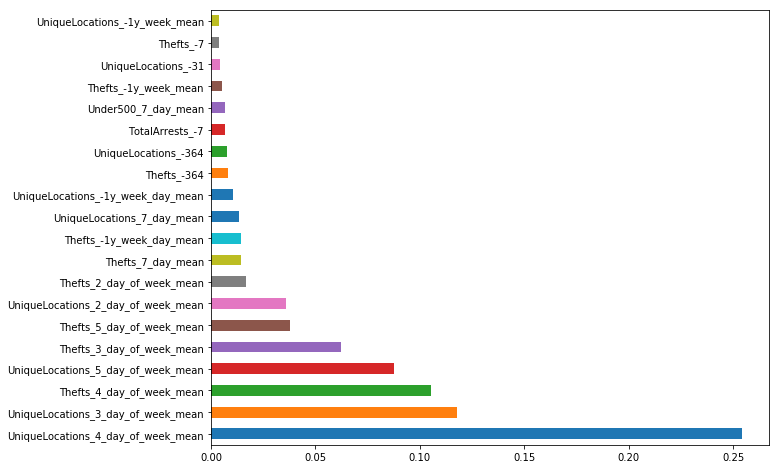

In [119]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh', figsize=(10,8))

In [129]:
fi = pd.read_csv("feat_importances.csv", header=None, index_col=0)

In [140]:
fi.pop(1)

Feature
Mean unique locations (-2 to -3 days)                   0.254368
Mean unique locations (same weekday -2 to -3 weeks)     0.117704
Total thefts (-2 to -4 days)                            0.105554
Mean unqiue locations (-2 to -5 days)                   0.087468
Total thefts (same weekday -3 weeks)                    0.062387
Mean thefts (-2 to -5 days)                             0.037679
Mean unique locations (same weekday -2 weeks)           0.035721
Mean thefts (same weekday -1 to -2 weeks)               0.016894
Mean thefts (-2 to -7 days)                             0.014399
Mean thefts (same week -1 year)                         0.014296
Mean unique locations (-2 to -7 days)                   0.013665
Mean unique locations (same week -1 year)               0.010488
Total thefts (same weekday -1 year)                     0.008241
Total unique locations (same weekday -1 year)           0.007520
Total arrests (-7 days)                                 0.006861
Mean thefts under

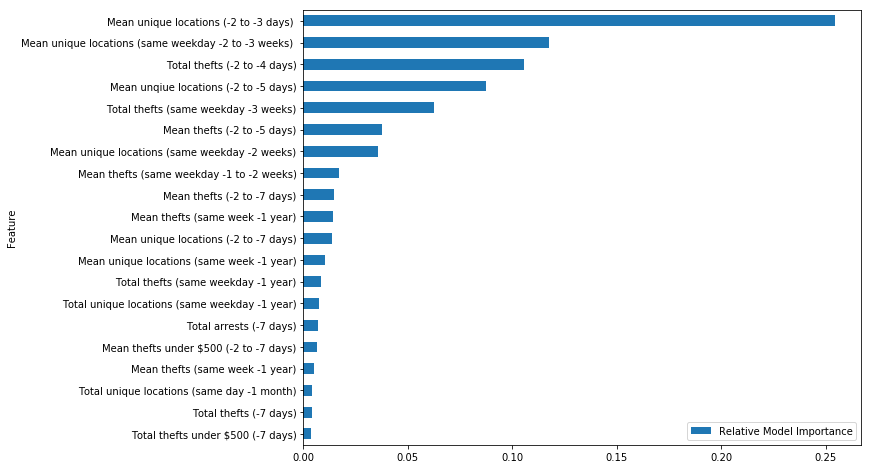

In [141]:
fi.iloc[::-1].plot(kind='barh', figsize=(10,8))

In [1341]:
NOW+relativedelta(years=-5, weekday=NOW.weekday())

datetime.datetime(2013, 3, 17, 16, 18, 9, 522847)

In [1342]:
NOW+relativedelta(days=-1820)

datetime.datetime(2013, 3, 17, 16, 18, 9, 522847)

In [1365]:
px = px.merge(weather, left_index=True, right_index=True, how='inner')

In [1367]:
px.head()

Thefts_-2  Thefts_-3  Thefts_-4  Thefts_-5  Thefts_-6  Thefts_-7  \
2002-01-07      202.0      206.0      211.0      266.0      344.0      222.0   
2002-01-08      175.0      202.0      206.0      211.0      266.0      344.0   
2002-01-09      217.0      175.0      202.0      206.0      211.0      266.0   
2002-01-10      221.0      217.0      175.0      202.0      206.0      211.0   
2002-01-11      250.0      221.0      217.0      175.0      202.0      206.0   

            Thefts_-8  Thefts_-9  Thefts_-10  Thefts_-11  ...   \
2002-01-07      165.0      217.0       226.0       195.0  ...    
2002-01-08      222.0      165.0       217.0       226.0  ...    
2002-01-09      344.0      222.0       165.0       217.0  ...    
2002-01-10      266.0      344.0       222.0       165.0  ...    
2002-01-11      211.0      266.0       344.0       222.0  ...    

            UniqueLocationRate_-371  UniqueLocationRate_-1y_week_day_mean  \
2002-01-07                 0.955556                              0.923675   
2002-01-08                 0.963801                              0.938598   
2002-01-09                 0.920354                              0.917466   
2002-01-10                 0.925926                              0.934711   
2002-01-11                 0.950382                              0.929155   

            UniqueLocationRate_-1y_week_mean  UniqueLocationRate_7_day_mean  \
2002-01-07                          0.921344                       0.944723   
2002-01-08                          0.924263                       0.947760   
2002-01-09                          0.922512                       0.942821   
2002-01-10                          0.916658                       0.942532   
2002-01-11                          0.927364                       0.945641   

            UniqueLocationRate_2_day_of_week_mean  \
2002-01-07                               0.908384   
2002-01-08                               0.973630   
2002-01-09                               0.917852   
2002-01-10                               0.955596   
2002-01-11                               0.944325   

            UniqueLocationRate_3_day_of_week_mean  \
2002-01-07                               0.919839   
2002-01-08                               0.956300   
2002-01-09                               0.909881   
2002-01-10                               0.950397   
2002-01-11                               0.941223   

            UniqueLocationRate_4_day_of_week_mean  \
2002-01-07                               0.921062   
2002-01-08                               0.942835   
2002-01-09                               0.921258   
2002-01-10                               0.938691   
2002-01-11                               0.945656   

            UniqueLocationRate_5_day_of_week_mean  PRCP  TEMP  
2002-01-07                               0.930265   0.0  83.5  
2002-01-08                               0.942353   0.0  86.5  
2002-01-09                               0.924408   0.0  71.0  
2002-01-10                               0.936027   0.0  73.5  
2002-01-11                               0.948751   0.0  37.5  

[5 rows x 398 columns]

In [1388]:
np.flip(np.logspace(0,2,num=5,base=10.0), axis=0)

array([100.        ,  31.6227766 ,  10.        ,   3.16227766,
         1.        ])

In [ ]:
from 